## Assingment 1 - Plotting Action

In [1854]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.patches import Circle
from matplotlib.patches import FancyArrowPatch
from PIL import Image as img
import seaborn as sns
from soccerplots.radar_chart import Radar
import warnings
from mplsoccer import Sbopen, Pitch, VerticalPitch
from mplsoccer.utils import add_image
from statsbombpy import sb
from kloppy import datafactory
from datetime import timedelta

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [1735]:
parser = Sbopen()
#dataset_test = datafactory.load(event_data='events_England.json')


## Expected Threat 

In [1751]:
df_match = parser.match(competition_id=72, season_id=107)

df_england_women = df_match.loc[(df_match['home_team_name']=="England Women's") | (df_match['away_team_name']=="England Women's")]
df_spain_women = df_match.loc[(df_match['home_team_name']=="Spain Women's") | (df_match['away_team_name']=="Spain Women's")]
df_sweden_women = df_match.loc[(df_match['home_team_name']=="Sweden Women's") | (df_match['away_team_name']=="Sweden Women's")]
df_australien_women = df_match.loc[(df_match['home_team_name']=="Australia Women's") | (df_match['away_team_name']=="Australia Women's")]


In [1752]:
def FindMatchesAndPlayerName(name, df):
    array =  []
    
    for match_id in df['match_id']:
        array.append(match_id)
    if not array:
        print("Array is empty")
    else:
        df_lineups = parser.lineup(match_id=array[0])
        df_player = df_lineups[df_lineups['player_name'].str.contains(name, case=False, na=False)]
        full_name = df_player['player_name'].iloc[0]
    
    return array, full_name

In [1753]:
a_match_id_spain_wc, sz_player_name_aitana_bonmati = FindMatchesAndPlayerName('Aitana', df_spain_women)
a_match_id_england_wc, sz_player_name_georgia_stanway = FindMatchesAndPlayerName('Stanway', df_england_women)
a_match_id_sweden_wc, sz_player_name_kosovare_asllani = FindMatchesAndPlayerName('Asllani', df_sweden_women)
a_match_id_australia_wc, sz_player_name_kyra_cooney = FindMatchesAndPlayerName('Kyra', df_australien_women)

a_match_id_for_the_teams = [a_match_id_spain_wc, a_match_id_england_wc, a_match_id_sweden_wc, a_match_id_australia_wc]
a_players_name = [sz_player_name_aitana_bonmati, sz_player_name_georgia_stanway, sz_player_name_kosovare_asllani, sz_player_name_kyra_cooney]

In [1754]:
def EventsOfEachMatch(a_match_id):
    a_of_df = []
    
    for match_id_per_team in a_match_id:
        for match_id_per_game in match_id_per_team:
            df_event = parser.event(match_id_per_game)
            if isinstance(df_event, tuple):
                df_event = df_event[0]
            a_of_df.append(df_event)
    
    events = events = pd.concat(a_of_df).reset_index()
    return events

In [1755]:
df_events_for_each_team = EventsOfEachMatch(a_match_id_for_the_teams)

In [1756]:
def EventsOfAPlayer(name, df):
    df_player = df[df['player_name'].str.contains(name, case=False, na=False)]
    return df_player

In [1757]:
df_aitana_bonmati = EventsOfAPlayer(sz_player_name_aitana_bonmati, df_events_for_each_team)
df_georgia_stanway = EventsOfAPlayer(sz_player_name_georgia_stanway, df_events_for_each_team)
df_kosovare_asllani = EventsOfAPlayer(sz_player_name_kosovare_asllani, df_events_for_each_team)
df_kyra_cooney = EventsOfAPlayer(sz_player_name_kyra_cooney, df_events_for_each_team)

df_players_events = pd.concat([df_aitana_bonmati, df_georgia_stanway, df_kosovare_asllani, df_kyra_cooney])



In [1758]:
def GetMinutesPlayedForAPlayer(name):
      
   n_total_min_played = 0
   processed_match_id = set()
   
   for sublist in a_match_id_for_the_teams:
      for match_id in sublist:
            if match_id in processed_match_id:
                  continue
            
            processed_match_id.add(match_id)
            df_match = df_players_events[df_players_events['match_id']==match_id]
            
            if name in df_match['player_name'].unique():  
                df_player = df_match[df_match['player_name']==name]
                
                if 'type_name' in df_player.columns:
                     df_subs = df_player[(df_player.player_name.str.contains(name)) & (df_player.type_name == 'Substitution')]
                     
                     if not df_subs.empty:
                           n_total_min_played += df_subs['minute'].max() + df_subs['second'].max() / 60
                     else:
                        n_total_min_played += df_player['minute'].max() + df_player['second'].max() / 60
                        
   return n_total_min_played
      

In [1759]:
mask_event = (df_players_events['type_name']=='Pass') | (df_players_events['type_name']=='Carry') | (df_players_events['outcome_name']) | (df_players_events['sub_type_name']!='Throw-in') | (df_players_events['player_name']) 
df_pass_and_carry_per_player = df_players_events[mask_event]


In [1760]:
df_pass_per_player = df_pass_and_carry_per_player.loc[df_pass_and_carry_per_player['type_name']=='Pass']
df_pass_per_player = df_pass_per_player[['player_name','type_name', 'sub_type_name', 'x', 'y', 'end_x', 'end_y','pass_recipient_name', 'outcome_name']] 
df_pass_per_player = df_pass_per_player[df_pass_per_player['outcome_name'].isna()]


In [1761]:
df_carry_per_player = df_pass_and_carry_per_player.loc[df_pass_and_carry_per_player['type_name']=='Carry']
df_carry_per_player = df_carry_per_player[['player_name','type_name', 'x', 'y', 'end_x', 'end_y', 'outcome_name']]

In [1762]:
xT = pd.read_csv('xT_Grid.csv', header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

In [1763]:
df_pass_per_player['x1_bin'] = pd.cut(df_pass_per_player['x'], bins = xT_cols, labels = False)
df_pass_per_player['y1_bin'] = pd.cut(df_pass_per_player['y'], bins = xT_rows, labels = False)
df_pass_per_player['x2_bin'] = pd.cut(df_pass_per_player['end_x'], bins = xT_cols, labels = False)
df_pass_per_player['y2_bin'] = pd.cut(df_pass_per_player['end_y'], bins = xT_rows, labels = False)

In [1764]:
df_carry_per_player['x1_bin'] = pd.cut(df_carry_per_player['x'], bins = xT_cols, labels = False)
df_carry_per_player['y1_bin'] = pd.cut(df_carry_per_player['y'], bins = xT_rows, labels = False)
df_carry_per_player['x2_bin'] = pd.cut(df_carry_per_player['end_x'], bins = xT_cols, labels = False)
df_carry_per_player['y2_bin'] = pd.cut(df_carry_per_player['end_y'], bins = xT_rows, labels = False)

In [1765]:
df_pass_per_player['start_zone_value'] = df_pass_per_player[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis = 1)
df_pass_per_player['end_zone_value'] = df_pass_per_player[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis = 1)

df_pass_per_player['xT'] = df_pass_per_player['end_zone_value'] - df_pass_per_player['start_zone_value']

df_carry_per_player['start_zone_value'] = df_carry_per_player[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis = 1)
df_carry_per_player['end_zone_value'] = df_carry_per_player[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis = 1)

df_carry_per_player['xT'] = df_carry_per_player['end_zone_value'] - df_carry_per_player['start_zone_value']


In [1766]:
def GetXTForAPlayer(name):
    
    df_xT_pass = df_pass_per_player.loc[df_pass_per_player['player_name'].str.contains(name)]
    df_xT_carry = df_carry_per_player.loc[df_carry_per_player['player_name'].str.contains(name)]
    
    return df_xT_pass.xT.sum(), df_xT_carry.xT.sum()

In [1767]:
n_aitana_bonmati_xT_pass, n_aitana_bonmati_xT_carry = GetXTForAPlayer(sz_player_name_aitana_bonmati)
n_georgie_stanway_xT_pass, n_georgie_stanway_xT_carry = GetXTForAPlayer(sz_player_name_georgia_stanway)
n_kosovare_asllani_xT_pass, n_kosovare_asllani_xT_carry = GetXTForAPlayer(sz_player_name_kosovare_asllani)
n_kyra_cooney_xT_pass, n_kyra_cooney_xT_carry = GetXTForAPlayer(sz_player_name_kyra_cooney)

In [1768]:
def CalculateXTPer90Min(name):
             
    n_player_min = GetMinutesPlayedForAPlayer(name)
    print(n_player_min)
    n_player_xT_pass, n_player_xT_carry = GetXTForAPlayer(name)
    n_player_xT_pass_per90 = (n_player_xT_pass / n_player_min) * 90
    n_player_xT_carry_per90 = (n_player_xT_carry / n_player_min) * 90
        
    return n_player_xT_pass_per90, n_player_xT_carry_per90
        

In [1910]:
df_xT = pd.DataFrame()

# Add the names of the player to the data frame df_xT 
df_xT['player_name'] = df_pass_and_carry_per_player['player_name'].astype(str)
df_xT = df_xT.groupby('player_name').sum().reset_index()
df_xT['minutes'] = df_xT['player_name'].map(GetMinutesPlayedForAPlayer)
df_xT[['xT_pass_p90', 'xT_carry_p90']] = df_xT['player_name'].apply(lambda name: pd.Series(CalculateXTPer90Min(name)))

df_xT.head()

611.6500000000001
651.9
475.68333333333334
696.9166666666667


,player_name,minutes,xT_pass_p90,xT_carry_p90
0,Aitana Bonmati Conca,611.650000,0.178000,0.058657
1,Georgia Stanway,651.900000,0.178510,0.018245
2,Kosovare Asllani,475.683333,0.295487,0.086359
3,Kyra Lillee Cooney-Cross,696.916667,0.260213,0.040841


Index(['player_name', 'type_name', 'x', 'y', 'end_x', 'end_y', 'outcome_name',
       'x1_bin', 'y1_bin', 'x2_bin', 'y2_bin', 'start_zone_value',
       'end_zone_value', 'xT'],
      dtype='object')

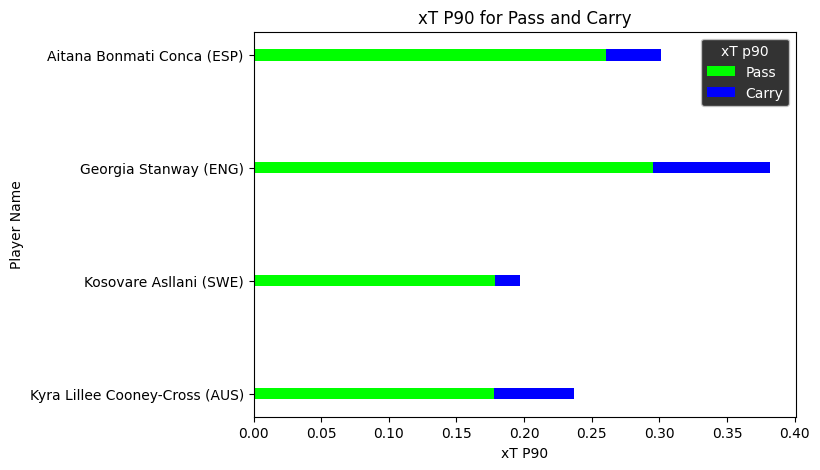

In [1936]:

bar_width = 0.1 
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
#image = plt.imread('womens_world_cup.jpeg')

#ax.imshow(image, extent=[0, 0.4, -0.5, len(df_xT)-0.5], alpha=0.3, aspect='auto')

df_xT['player_name_with_country'] = [
    "Kyra Lillee Cooney-Cross (AUS)",
    "Kosovare Asllani (SWE)",
    "Georgia Stanway (ENG)",
    "Aitana Bonmati Conca (ESP)"
]

names_list = list(df_xT.player_name_with_country)
xT_pass_list = list(df_xT.xT_pass_p90)
xT_carry_list = list(df_xT.xT_carry_p90)

b1 = ax.barh(names_list, xT_pass_list, color='lime', label="Pass", height=bar_width)
b2 = ax.barh(names_list, xT_carry_list, color='blue', label="Carry", left=xT_pass_list, height=bar_width) 

ax.tick_params(axis='x', colors='black')  
ax.tick_params(axis='y', colors='black') 

ax.spines['bottom'].set_color('black')  # Ändrar färgen på x-axeln
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')

ax.set_xlabel('xT P90', color='black')  # Ändrar färgen på x-axelns etikett
ax.set_ylabel('Player Name', color='black') 
ax.patch.set_facecolor(color='white')
ax.legend(title="xT p90", loc="upper right")

# Lägg till etiketter och rubrik
ax.set_xlabel('xT P90', color='black')
ax.set_title('xT P90 for Pass and Carry', color='black')


df_carry_per_player.columns


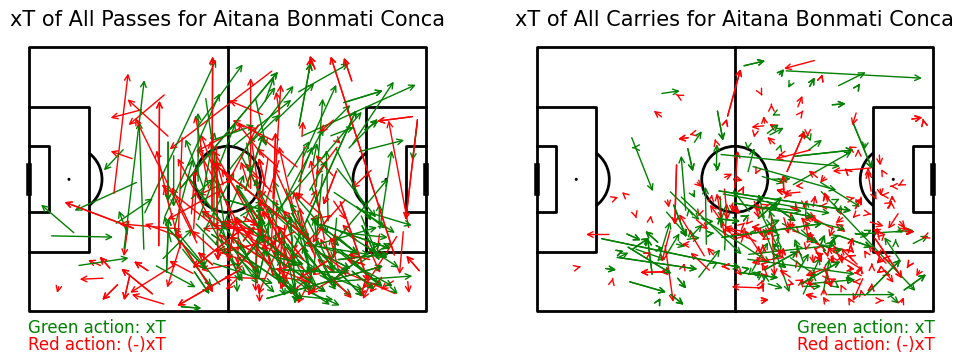

In [1947]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='None', line_color='black')
fig, ax = pitch.draw(ncols=2,tight_layout=False, figsize=(12,12))
fig.patch.set_facecolor('white')
wc_image = img.open('womens_world_cup.jpeg')
#ax_image = add_image(wc_image, fig, left=0, bottom=0, width=1.06, height=0.90, alpha=0.3)

n = 0

df_plot_pass_aitana = df_pass_per_player[['player_name', 'type_name', 'sub_type_name', 'x', 'y', 'end_x', 'end_y', 'outcome_name', 'xT']]
df_plot_carry_aitana = df_carry_per_player[['player_name', 'type_name','x', 'y', 'end_x', 'end_y', 'outcome_name', 'xT']]

mask_carry = (df_plot_carry_aitana['player_name'].str.contains(sz_player_name_aitana_bonmati)) & (df_plot_carry_aitana['outcome_name'].isna())

df_plot_pass_aitana = df_plot_pass_aitana.loc[df_plot_pass_aitana['player_name'].str.contains(sz_player_name_aitana_bonmati)]
df_plot_pass_aitana = df_plot_pass_aitana.loc[df_plot_pass_aitana['outcome_name'].isna()]
df_plot_pass_aitana = df_plot_pass_aitana.loc[df_plot_pass_aitana['sub_type_name']!='Throw-in']
df_plot_carry_aitana = df_plot_carry_aitana.loc[mask_carry]

for i, the_pass in df_plot_pass_aitana.iterrows():
    x = the_pass['x']
    y = the_pass['y']
    end_x = the_pass['end_x']
    end_y = the_pass['end_y']
    xT_value = the_pass['xT']
    
    if xT_value > 0:
        ax[0].annotate('', xy=(end_x, end_y), xytext=(x, y),arrowprops=dict(facecolor='green', edgecolor='green' ,arrowstyle='->'))
    else:
        ax[0].annotate('', xy=(end_x, end_y), xytext=(x, y),arrowprops=dict(facecolor='red', edgecolor='red' ,arrowstyle='->'))
    
for i, the_carry in df_plot_carry_aitana.iterrows():
    x = the_carry['x']
    y = the_carry['y']
    end_x = the_carry['end_x']
    end_y = the_carry['end_y']
    xT_value = the_carry['xT']
    
    if xT_value > 0:
        ax[1].annotate('', xy=(end_x, end_y), xytext=(x, y),arrowprops=dict(facecolor='green', edgecolor='green' ,arrowstyle='->'))
    else:
        ax[1].annotate('', xy=(end_x, end_y), xytext=(x, y),arrowprops=dict(facecolor='red', edgecolor='red' ,arrowstyle='->'))


ax[0].set_title('xT of All Passes for ' + sz_player_name_aitana_bonmati, fontsize = 15, color='black')
ax[1].set_title('xT of All Carries for ' + sz_player_name_aitana_bonmati, fontsize = 15, color='black')
ax[0].text(0.19, -0.01, 'Green action: xT', ha='center', va='center', transform=ax[0].transAxes, fontsize=12, color='green')
ax[0].text(0.19, -0.07, 'Red action: (-)xT', ha='center', va='center', transform=ax[0].transAxes, fontsize=12, color='red')
ax[1].text(2.01, -0.01, 'Green action: xT', ha='center', va='center', transform=ax[0].transAxes, fontsize=12, color='green')
ax[1].text(2.01, -0.07, 'Red action: (-)xT', ha='center', va='center', transform=ax[0].transAxes, fontsize=12, color='red')

plt.show()
